In [197]:
from kan import *
import torch
import pandas as pd


def load_csv_data(train_csv, test_csv, normalize_input=False, normalize_label=False, device='cpu'):
    """
    Load training and testing data from CSV files and process them into the format 
    compatible with the output of the create_dataset function.
    
    Args:
    -----
        train_csv : str
            Path to the CSV file containing the training data.
        test_csv : str
            Path to the CSV file containing the testing data.
        normalize_input : bool
            If True, apply normalization to inputs. Default: False.
        normalize_label : bool
            If True, apply normalization to labels. Default: False.
        device : str
            Device to move the data to ('cpu' or 'cuda'). Default: 'cpu'.
            
    Returns:
    --------
        dataset : dict
            Train/test inputs/labels are stored in dataset['train_input'], dataset['train_label'],
            dataset['test_input'], dataset['test_label']
    """
    # Load data from CSV files
    train_df = pd.read_csv(train_csv, header=None)
    test_df = pd.read_csv(test_csv, header=None)

    # Determine number of features (all columns except the last one are considered as features)
    n_var = train_df.shape[1] - 1

    # Split inputs and labels
    train_input = torch.tensor(train_df.iloc[:, :n_var].values, dtype=torch.float32)
    train_label = torch.tensor(train_df.iloc[:, n_var].values, dtype=torch.float32).unsqueeze(1)
    test_input = torch.tensor(test_df.iloc[:, :n_var].values, dtype=torch.float32)
    test_label = torch.tensor(test_df.iloc[:, n_var].values, dtype=torch.float32).unsqueeze(1)

    # Print shapes for debugging
    print(f'train_input shape: {train_input.shape}')
    print(f'train_label shape: {train_label.shape}')
    print(f'test_input shape: {test_input.shape}')
    print(f'test_label shape: {test_label.shape}')
    
    def normalize(data, mean, std):
        return (data - mean) / std
    
    if normalize_input:
        mean_input = torch.mean(train_input, dim=0, keepdim=True)
        std_input = torch.std(train_input, dim=0, keepdim=True)
        train_input = normalize(train_input, mean_input, std_input)
        test_input = normalize(test_input, mean_input, std_input)
        
    if normalize_label:
        mean_label = torch.mean(train_label, dim=0, keepdim=True)
        std_label = torch.std(train_label, dim=0, keepdim=True)
        train_label = normalize(train_label, mean_label, std_label)
        test_label = normalize(test_label, mean_label, std_label)

    dataset = {
        'train_input': train_input.to(device),
        'train_label': train_label.to(device),
        'test_input': test_input.to(device),
        'test_label': test_label.to(device)
    }

    return dataset




In [337]:
#Example usage:
dataset = load_csv_data('Nguyen-12.csv', 'Nguyen-12_test.csv', normalize_input=False, normalize_label=False)

train_input shape: torch.Size([20, 2])
train_label shape: torch.Size([20, 1])
test_input shape: torch.Size([20, 2])
test_label shape: torch.Size([20, 1])


In [338]:
# Define the new function based on the given formula
f = lambda x: x[:,[0]]**3 + x[:,[0]]**2 + x[:,[0]]

# Create a dataset with the new function
# Ensure the parameters match the function's requirements
#dataset = create_dataset(f, n_var=1)

# Check the shapes of the dataset components to ensure they are correct
print("train_input shape:", dataset['train_input'].shape)
print("train_label shape:", dataset['train_label'].shape)
print("test_input shape:", dataset['test_input'].shape)
print("test_label shape:", dataset['test_label'].shape)
#dataset = load_csv_data('Nguyen-1.csv','Nguyen-1_test.csv')


train_input shape: torch.Size([20, 2])
train_label shape: torch.Size([20, 1])
test_input shape: torch.Size([20, 2])
test_label shape: torch.Size([20, 1])


In [359]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,2,2,1], grid=50, k=3, seed=0)

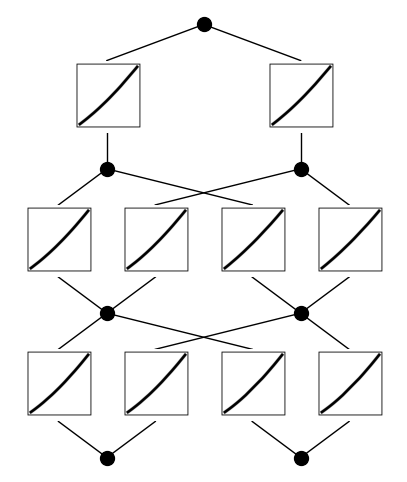

In [350]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

In [351]:
# train the model
model.train(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.);

train loss: 1.67e-01 | test loss: 1.49e-01 | reg: 1.47e+01 : 100%|██| 20/20 [00:03<00:00,  5.68it/s]


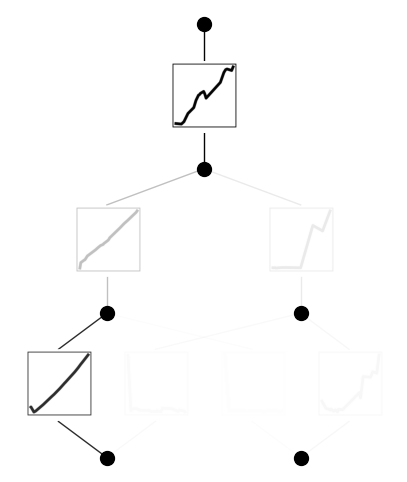

In [352]:
model = model.prune()
model(dataset['train_input'])
model.plot()

In [353]:
model.train(dataset, opt="LBFGS", steps=50);

train loss: 1.25e-01 | test loss: 1.78e-01 | reg: 4.75e+00 : 100%|██| 50/50 [00:07<00:00,  6.59it/s]


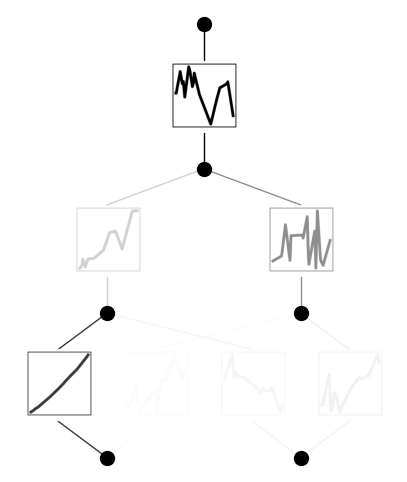

In [354]:
model.plot()

In [355]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    #lib = ['x','x^2','x^3','x^4']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9998501539230347
fixing (0,0,1) with tanh, r2=0.7215104699134827
fixing (0,1,0) with abs, r2=0.8250332474708557
fixing (0,1,1) with sin, r2=0.7402026057243347
fixing (1,0,0) with exp, r2=0.891706645488739
fixing (1,1,0) with log, r2=0.08820916712284088
fixing (2,0,0) with abs, r2=0.27566465735435486


In [358]:
#model.train(dataset, opt="LBFGS", steps=50);

In [356]:
model.symbolic_formula()[0][0]

-0.06*Abs(1.62*exp(0.21*(0.85*x_1 + 1)**2) + 0.02*log(0.12*sin(3.71*x_2 - 2.44) + 0.03*tanh(10.0*x_1 - 5.5) + 0.19) - 2.14) - 0.27